In [9]:
# imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

In [10]:
# read in dataset
df = pd.read_csv("LengthOfStay.csv")
df.head(3)

,eid,vdate,rcount,gender,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,...,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,discharged,facid,lengthofstay
0,1,8/29/2012,0,F,0,0,0,0,0,0,...,192.476918,12.0,1.390722,30.432418,96,6.5,4,9/1/2012,B,3
1,2,5/26/2012,5+,F,0,0,0,0,0,0,...,94.078507,8.0,0.943164,28.460516,61,6.5,1,6/2/2012,A,7
2,3,9/22/2012,1,F,0,0,0,0,0,0,...,130.530524,12.0,1.065750,28.843812,64,6.5,2,9/25/2012,B,3


In [11]:
# Detailed column description - https://microsoft.github.io/r-server-hospital-length-of-stay/input_data.html

import requests
from bs4 import BeautifulSoup

def scrape_table(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    table = soup.find('table')
    if not table:
        print("No table found on the webpage.")
        return
    
    headers = [header.text.strip() for header in table.find_all('th')]
    rows = []
    
    for row in table.find_all('tr'):
        row_data = [data.text.strip() for data in row.find_all('td')]
        if row_data:
            rows.append(row_data)
    
    return headers, rows

# Example usage
url = 'https://microsoft.github.io/r-server-hospital-length-of-stay/input_data.html'
table_headers, table_rows = scrape_table(url)

column_description = pd.DataFrame(table_rows,columns=table_headers)

column_description.head(2)

,Index,Data Field,Type,Description
0,1,eid,Integer,Unique Id of the hospital admission
1,2,vdate,String,Visit date


In [12]:
column_description

,Index,Data Field,Type,Description
0,1,eid,Integer,Unique Id of the hospital admission
1,2,vdate,String,Visit date
2,3,rcount,Integer,Number of readmissions within last 180 days
3,4,gender,String,Gender of the patient - M or F
4,5,dialysisrenalendstage,String,Flag for renal disease during encounter
5,6,asthma,String,Flag for asthma during encounter
6,7,irondef,String,Flag for iron deficiency during encounter
7,8,pneum,String,Flag for pneumonia during encounter
8,9,substancedependence,String,Flag for substance dependence during encounter
9,10,psychologicaldisordermajor,String,Flag for major psychological disorder during e...


### Checking NaN values

In [13]:
df.isna().sum()

eid                           0
vdate                         0
rcount                        0
gender                        0
dialysisrenalendstage         0
asthma                        0
irondef                       0
pneum                         0
substancedependence           0
psychologicaldisordermajor    0
depress                       0
psychother                    0
fibrosisandother              0
malnutrition                  0
hemo                          0
hematocrit                    0
neutrophils                   0
sodium                        0
glucose                       0
bloodureanitro                0
creatinine                    0
bmi                           0
pulse                         0
respiration                   0
secondarydiagnosisnonicd9     0
discharged                    0
facid                         0
lengthofstay                  0
dtype: int64

### Let's See count of valuies in each end every columns

In [14]:
for col in df.columns:

    print("Column : ",col)
    print(df[col].value_counts())
    print()
    print("---------------------------------")

Column :  eid
eid
1         1
66651     1
66673     1
66672     1
66671     1
         ..
33332     1
33331     1
33330     1
33329     1
100000    1
Name: count, Length: 100000, dtype: int64

---------------------------------
Column :  vdate
vdate
10/3/2012     333
6/14/2012     324
11/11/2012    324
9/27/2012     317
2/22/2012     315
             ... 
1/11/2012     230
7/6/2012      229
4/11/2012     227
12/1/2012     214
3/20/2012     212
Name: count, Length: 367, dtype: int64

---------------------------------
Column :  rcount
rcount
0     55031
1     15007
2      9987
3      8047
4      6941
5+     4987
Name: count, dtype: int64

---------------------------------
Column :  gender
gender
F    57643
M    42357
Name: count, dtype: int64

---------------------------------
Column :  dialysisrenalendstage
dialysisrenalendstage
0    96358
1     3642
Name: count, dtype: int64

---------------------------------
Column :  asthma
asthma
0    96473
1     3527
Name: count, dtype: int64

-----

>> There are 3 date columns, 8 numeric columns and others are categorical columns

### Data Cleaning

In [15]:
# type conversions 
datetime_cols = ["vdate", "discharged"]
cat_cols = ["gender", "rcount", "facid"]

num_cols = ["hematocrit",
            "neutrophils",
            "sodium",
            "glucose",
            "bloodureanitro",
            "creatinine",
            "bmi",
            "respiration"]

bin_cols = ["dialysisrenalendstage", 
            "asthma", 
            "irondef", 
            "pneum", 
            "substancedependence", 
            "psychologicaldisordermajor",
            "depress",
            "psychother",
            "fibrosisandother",
            "malnutrition",
            "hemo"]

for date_col in datetime_cols: 
    df[date_col] = pd.to_datetime(df[date_col], format="%m/%d/%Y")
for cat_col in cat_cols: 
    df[cat_col] = df[cat_col].astype("category")
df.head()

,eid,vdate,rcount,gender,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,...,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,discharged,facid,lengthofstay
0,1,2012-08-29,0,F,0,0,0,0,0,0,...,192.476918,12.0,1.390722,30.432418,96,6.5,4,2012-09-01,B,3
1,2,2012-05-26,5+,F,0,0,0,0,0,0,...,94.078507,8.0,0.943164,28.460516,61,6.5,1,2012-06-02,A,7
2,3,2012-09-22,1,F,0,0,0,0,0,0,...,130.530524,12.0,1.065750,28.843812,64,6.5,2,2012-09-25,B,3
3,4,2012-08-09,0,F,0,0,0,0,0,0,...,163.377028,12.0,0.906862,27.959007,76,6.5,1,2012-08-10,A,1
4,5,2012-12-20,0,F,0,0,0,1,0,1,...,94.886654,11.5,1.242854,30.258927,67,5.6,2,2012-12-24,E,4


In [16]:
### Creating new column based on issues recorded

df["numberofissues"] = df[bin_cols].sum(axis=1)



### Exploratory Data Analysis

In [17]:
import seaborn as sns

<Axes: xlabel='lengthofstay', ylabel='hematocrit'>

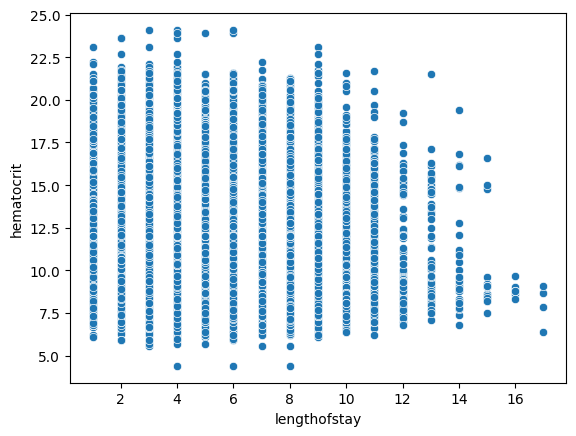

In [18]:

sns.scatterplot(data=df,y=df["hematocrit"],x=df["lengthofstay"])

<Axes: xlabel='neutrophils', ylabel='lengthofstay'>

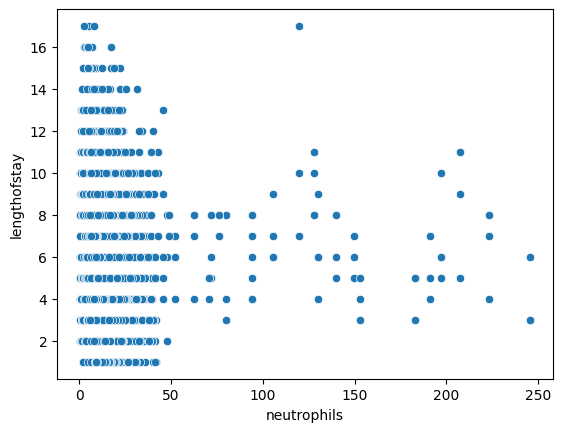

In [19]:
sns.scatterplot(data=df,x=df["neutrophils"],y=df["lengthofstay"])

<Axes: xlabel='sodium', ylabel='lengthofstay'>

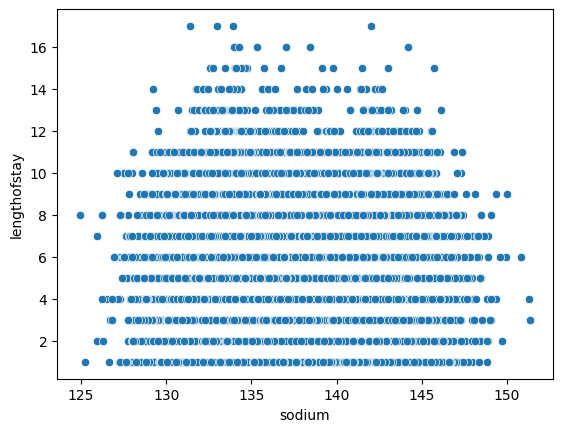

In [20]:
sns.scatterplot(data=df,x=df["sodium"],y=df["lengthofstay"])


<Axes: xlabel='glucose', ylabel='lengthofstay'>

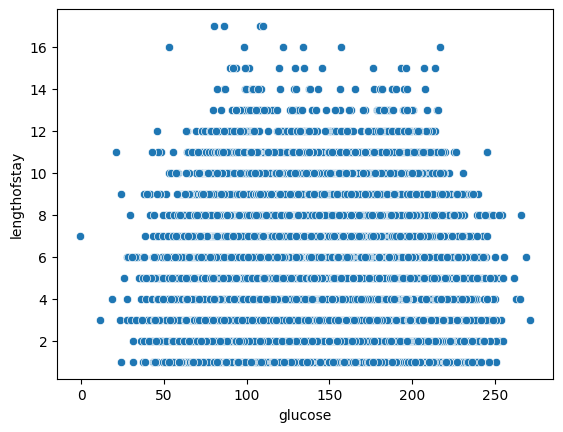

In [21]:
sns.scatterplot(data=df,x=df["glucose"],y=df["lengthofstay"])

<Axes: xlabel='bloodureanitro', ylabel='lengthofstay'>

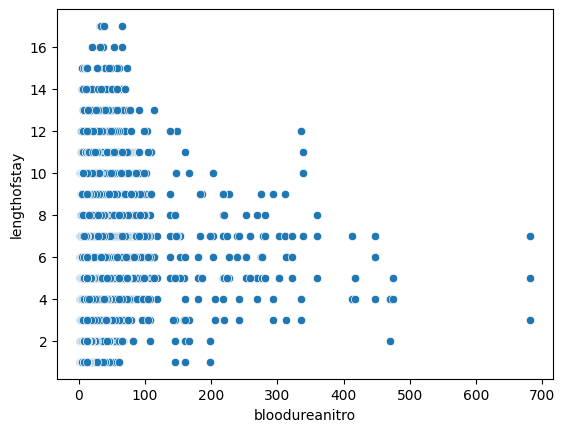

In [22]:
sns.scatterplot(data=df,x=df["bloodureanitro"],y=df["lengthofstay"])


<Axes: xlabel='creatinine', ylabel='lengthofstay'>

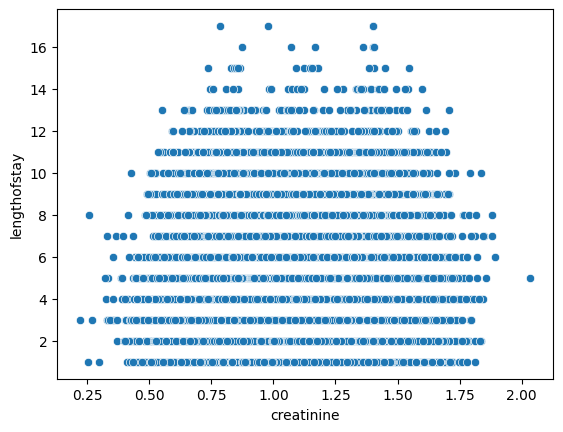

In [23]:

sns.scatterplot(data=df,x=df["creatinine"],y=df["lengthofstay"])


<Axes: xlabel='numberofissues', ylabel='lengthofstay'>

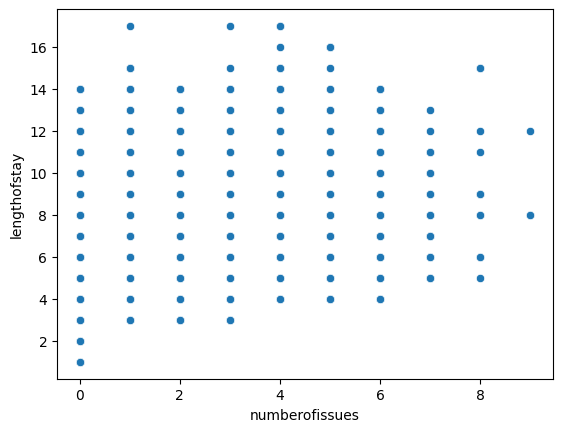

In [24]:


sns.scatterplot(data=df,x=df["numberofissues"],y=df["lengthofstay"])


### Model Building

In [25]:
# Preparing the data

labels, features = df[["lengthofstay"]], df.drop(["lengthofstay", "discharged", "vdate", "eid"], axis=1)
labels.value_counts()

lengthofstay
1               17979
3               16068
4               14822
2               12825
5               12116
6               10362
7                7263
8                4652
9                2184
10               1000
11                460
12                137
13                 75
14                 31
15                 16
16                  6
17                  4
Name: count, dtype: int64

In [27]:
# Splitting data into train test split

x_train, x_test, y_train, y_test = train_test_split(features, labels)

In [172]:
# Data pre-processing

In [28]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [29]:
scaler = StandardScaler()

In [30]:
def prepare_train_data(x_train):

    cat_features = pd.get_dummies(x_train[cat_cols],drop_first=True)

    x_train.drop(cat_cols,axis=1,inplace=True)

    x_train = pd.concat([cat_features,x_train],axis=1)

    number_features = pd.DataFrame(scaler.fit_transform(x_train[num_cols]),columns=x_train[num_cols].columns,index=x_train.index.tolist())

    x_train.drop(num_cols,axis=1,inplace=True)

    x_train = pd.concat([number_features,x_train],axis=1)

    return x_train

x_train = prepare_train_data(x_train)

In [31]:
def prepare_data(x_test):

    cat_features = pd.get_dummies(x_test[cat_cols],drop_first=True)

    x_test.drop(cat_cols,axis=1,inplace=True)

    x_test = pd.concat([cat_features,x_test],axis=1)

    number_features = pd.DataFrame(scaler.transform(x_test[num_cols]),columns=x_test[num_cols].columns,index=x_test.index.tolist())

    x_test.drop(num_cols,axis=1,inplace=True)

    x_test = pd.concat([number_features,x_test],axis=1)

    return x_test

x_test = prepare_data(x_test)

In [32]:
from xgboost import XGBRegressor

In [33]:
xgbModel = XGBRegressor()

In [34]:
xgbModel.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [35]:
predicted = xgbModel.predict(x_test)

In [36]:
### Evaluating the model

from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error

predicted = xgbModel.predict(x_test)

print("R2 Score is : ",r2_score(predicted,y_test))

print("Mean Squared Error is : ",mean_squared_error(predicted,y_test))

print("Mean Absolute Error is : ",mean_absolute_error(predicted,y_test))


R2 Score is :  0.9700213618190064
Mean Squared Error is :  0.16209131992803621
Mean Absolute Error is :  0.3022007790231705


In [63]:
xgbModel.feature_names_in_[np.argsort(xgbModel.feature_importances_)[::-1]],xgbModel.feature_importances_[np.argsort(xgbModel.feature_importances_)[::-1]]

(array(['rcount_5+', 'rcount_4', 'rcount_3', 'rcount_2', 'numberofissues',
        'rcount_1', 'respiration', 'hematocrit', 'pulse', 'bloodureanitro',
        'sodium', 'glucose', 'bmi', 'creatinine', 'neutrophils', 'facid_E',
        'psychologicaldisordermajor', 'dialysisrenalendstage', 'pneum',
        'hemo', 'malnutrition', 'fibrosisandother', 'facid_C', 'asthma',
        'irondef', 'facid_D', 'secondarydiagnosisnonicd9', 'gender_M',
        'facid_B', 'substancedependence', 'depress', 'psychother'],
       dtype='<U26'),
 array([2.8694627e-01, 2.3520972e-01, 2.0138747e-01, 1.3239266e-01,
        8.4723204e-02, 2.5402106e-02, 5.4347422e-03, 4.5172158e-03,
        4.0508867e-03, 3.2843612e-03, 3.0558417e-03, 3.0322266e-03,
        2.7366846e-03, 2.7104421e-03, 2.5335213e-03, 3.2739597e-04,
        2.4197095e-04, 2.2820941e-04, 2.2056542e-04, 1.9664985e-04,
        1.7595230e-04, 1.6566965e-04, 1.6492531e-04, 1.2850846e-04,
        1.1977451e-04, 1.1634991e-04, 1.0274957e-04, 9.3790

In [64]:
for i,j in zip(xgbModel.feature_names_in_[np.argsort(xgbModel.feature_importances_)[::-1]],xgbModel.feature_importances_[np.argsort(xgbModel.feature_importances_)[::-1]]):

    try:

        print(list(column_description[column_description["Data Field"]==i]["Description"])[0],"-",i,":",np.round(j,6))

    except:
        print(i,j)

rcount_5+ 0.28694627
rcount_4 0.23520972
rcount_3 0.20138747
rcount_2 0.13239266
numberofissues 0.084723204
rcount_1 0.025402106
Average respiration during encounter  (breaths/m) - respiration : 0.005435
Average hematocrit value during encounter (g/dL) - hematocrit : 0.004517
Average pulse during encounter  (beats/m) - pulse : 0.004051
Average blood urea nitrogen value during encounter (mg/dL) - bloodureanitro : 0.003284
Average sodium value during encounter (mmol/L) - sodium : 0.003056
Average sodium value during encounter (mmol/L) - glucose : 0.003032
Average BMI during encounter (kg/m2) - bmi : 0.002737
Average creatinine value during encounter (mg/dL) - creatinine : 0.00271
Average neutrophils value during encounter  (cells/microL) - neutrophils : 0.002534
facid_E 0.00032739597
Flag for major psychological disorder during encounter - psychologicaldisordermajor : 0.000242
Flag for renal disease during encounter - dialysisrenalendstage : 0.000228
Flag for pneumonia during encounter -

In [212]:
feature_importance = xgbModel.feature_names_in_[np.argsort(xgbModel.feature_importances_)[::-1]]

In [66]:
xgbModel.feature_importances_[13]

0.28694627

In [218]:
df["rcount"].value_counts()

rcount
0     55031
1     15007
2      9987
3      8047
4      6941
5+     4987
Name: count, dtype: int64

In [219]:
column_description

,Index,Data Field,Type,Description
0,1,eid,Integer,Unique Id of the hospital admission
1,2,vdate,String,Visit date
2,3,rcount,Integer,Number of readmissions within last 180 days
3,4,gender,String,Gender of the patient - M or F
4,5,dialysisrenalendstage,String,Flag for renal disease during encounter
5,6,asthma,String,Flag for asthma during encounter
6,7,irondef,String,Flag for iron deficiency during encounter
7,8,pneum,String,Flag for pneumonia during encounter
8,9,substancedependence,String,Flag for substance dependence during encounter
9,10,psychologicaldisordermajor,String,Flag for major psychological disorder during e...


In [220]:
import numpy as np
import pandas as pd
import random
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(42)

# Define the number of samples
num_samples = 200000

# Generate synthetic data
data = {
    'Age': np.random.randint(18, 90, num_samples),
    'Gender': np.random.choice(['Male', 'Female'], num_samples),
    'Ethnicity': np.random.choice(['Asian', 'Black', 'Hispanic', 'White'], num_samples),
    'AdmissionType': np.random.choice(['Emergency', 'Elective', 'Urgent'], num_samples),
    'SourceOfAdmission': np.random.choice(['Emergency Department', 'Another Hospital', 'Referral'], num_samples),
    'TimeOfAdmission': [],
    'PrimaryDiagnosis': np.random.choice(['Infection', 'Injury', 'Cardiovascular', 'Respiratory'], num_samples),
    'Comorbidities': np.random.randint(0, 5, num_samples),
    'PreviousHospitalizations': np.random.randint(0, 10, num_samples),
    'Medications': np.random.choice(['Medication A', 'Medication B', 'Medication C'], num_samples),
    'BloodPressureSystolic': np.random.randint(80, 180, num_samples),
    'BloodPressureDiastolic': np.random.randint(50, 120, num_samples),
    'HeartRate': np.random.randint(50, 120, num_samples),
    'RespiratoryRate': np.random.randint(10, 30, num_samples),
    'Temperature': np.random.normal(98.6, 1.5, num_samples),
    'LabTestResultA': np.random.normal(50, 10, num_samples),
    'LabTestResultB': np.random.normal(5, 1, num_samples),
    'Surgery': np.random.choice([0, 1], num_samples),
    'Procedures': np.random.choice(['Procedure A', 'Procedure B', 'Procedure C'], num_samples),
    'MedicationsAdministered': np.random.choice(['Medication X', 'Medication Y', 'Medication Z'], num_samples),
    'ICUAdmission': np.random.choice([0, 1], num_samples),
    'DaysInICU': np.random.randint(0, 20, num_samples),
    'DaysOnVentilator': np.random.randint(0, 10, num_samples),
    'DischargeDisposition': np.random.choice(['Home', 'Another Facility'], num_samples),
    'InsuranceType': np.random.choice(['Private', 'Public', 'None'], num_samples),
    'MaritalStatus': np.random.choice(['Single', 'Married', 'Divorced', 'Widowed'], num_samples),
    'LivingConditions': np.random.choice(['Alone', 'With Family', 'Nursing Home'], num_samples)
}

# Generate random admission timestamps within a range of 6 months
start_date = datetime(2023, 1, 1)
end_date = start_date + timedelta(days=180)

for _ in range(num_samples):
    admission_timestamp = random.uniform(start_date.timestamp(), end_date.timestamp())
    data['TimeOfAdmission'].append(datetime.fromtimestamp(admission_timestamp))

# Generate the target variable with a clear relationship
age_coefficient = 0.25
comorbidities_coefficient = 0.5
days_in_icu_coefficient = 1.2

data['LengthOfStay'] = (
    age_coefficient * data['Age'] +
    comorbidities_coefficient * data['Comorbidities'] +
    days_in_icu_coefficient * data['DaysInICU'] +
    np.random.normal(0, 5, num_samples)  # Adding some random noise
)

# Create a DataFrame from the generated data
df = pd.DataFrame(data)

# Save the synthetic data to a CSV file
df.to_csv('synthetic_data.csv', index=False)


In [69]:
data = "data & dict"

new_data = "data /& dict"

In [70]:
import re

In [78]:
special = re.search("[^a-zA-Z0-9\s]",data)

In [110]:
import random
import pandas as pd

# Set random seed for reproducibility
random.seed(42)

# Define hospital names and departments
hospitals = ['St. Mary Hospital', 'General Medical Center', 'City Health Center', 'Hope Medical Center']

# departments = ['General','Cardiology', 'Orthopedics', 'Neurology', 'Oncology', 'Pulmonology', 'Dermatology', 'Endocrinology','Ophthalmology','Dental Medicine','Otolaryngology']

departments = [
    'Cardiology',
    'Oncology',
    'Neurology',
    'Pulmonology',
    'Ophthalmology',
    'Orthopedics',
    'Dermatology',
    'Endocrinology',
    'Otolaryngology',
    'Dental Medicine',
    'General',
    'Pediatrics'
]


department_health_issues = {
    'Cardiology': ['Heart disease', 'Arrhythmia', 'Coronary artery disease', 'Heart failure', 'Hypertension',
                   'Angina', 'Atherosclerosis', 'Cardiac arrest', 'Congenital heart defects', 'Myocardial infarction',
                   'Pericarditis', 'Rheumatic heart disease', 'Cardiomyopathy', 'Endocarditis', 'Heart valve disorders',
                   'Pulmonary hypertension', 'Peripheral artery disease', 'Cardiac arrhythmias', 'Cardiac murmurs',
                   'Vascular diseases'],
    'Oncology': ['Cancer', 'Leukemia', 'Breast cancer', 'Lung cancer', 'Colon cancer',
                 'Prostate cancer', 'Melanoma', 'Ovarian cancer', 'Pancreatic cancer', 'Liver cancer',
                 'Kidney cancer', 'Bladder cancer', 'Brain tumors', 'Hodgkin lymphoma', 'Non-Hodgkin lymphoma',
                 'Gastric (stomach) cancer', 'Esophageal cancer', 'Cervical cancer', 'Thyroid cancer',
                 'Testicular cancer'],
    'Neurology': ['Stroke', 'Epilepsy', 'Migraine', 'Alzheimer\'s disease', 'Parkinson\'s disease',
                  'Multiple sclerosis', 'Amyotrophic lateral sclerosis (ALS)', 'Neuropathy', 'Meningitis', 'Encephalitis',
                  'Traumatic brain injury', 'Brain aneurysm', 'Spinal cord injury', 'Huntington\'s disease', 'Myasthenia gravis',
                  'Restless legs syndrome', 'Neurofibromatosis', 'Cerebral palsy', 'Bell\'s palsy', 'Guillain-Barré syndrome'],
    'Pulmonology': ['Asthma', 'Chronic obstructive pulmonary disease (COPD)', 'Pneumonia', 'Lung fibrosis', 'Bronchitis',
                    'Emphysema', 'Lung cancer', 'Pulmonary embolism', 'Tuberculosis', 'Cystic fibrosis',
                    'Pulmonary hypertension', 'Obstructive sleep apnea', 'Idiopathic pulmonary fibrosis', 'Sarcoidosis',
                    'Pleural effusion', 'Pleural disorders', 'Pulmonary edema', 'Pulmonary nodules', 'Respiratory failure',
                    'Interstitial lung diseases'],
    'Ophthalmology': ['Cataracts', 'Glaucoma', 'Macular degeneration', 'Refractive errors', 'Conjunctivitis',
                      'Dry eyes', 'Retinal detachment', 'Diabetic retinopathy', 'Strabismus', 'Amblyopia',
                      'Keratoconus', 'Blepharitis', 'Uveitis', 'Optic neuritis', 'Color blindness',
                      'Ptosis (droopy eyelid)', 'Corneal diseases', 'Eyelid disorders', 'Orbital disorders', 'Nystagmus'],
    'Orthopedics': ['Fractures', 'Arthritis', 'Osteoporosis', 'Spinal disorders', 'Sports injuries',
                    'Tendonitis', 'Carpal tunnel syndrome', 'Rotator cuff injuries', 'Scoliosis', 'Ligament tears',
                    'Hip replacement', 'Knee replacement', 'Herniated disc', 'Bursitis', 'Gout',
                    'Muscle strains and sprains', 'Dislocations', 'Osteomyelitis', 'Sciatica', 'Fibromyalgia'],
    'Dermatology': ['Acne', 'Eczema', 'Psoriasis', 'Skin cancer', 'Rosacea',
                    'Dermatitis', 'Hives', 'Warts', 'Melasma', 'Vitiligo',
                    'Fungal infections', 'Herpes', 'Cellulitis', 'Hair loss', 'Nail disorders',
                    'Seborrheic keratosis', 'Melanoma', 'Moles', 'Rashes', 'Sunburn'],
    'Endocrinology': ['Diabetes', 'Thyroid disorders', 'Obesity', 'Polycystic ovary syndrome (PCOS)', 'Cushing\'s syndrome',
                      'Hyperthyroidism', 'Hypothyroidism', 'Graves\' disease', 'Goiter', 'Thyroid nodules',
                      'Adrenal insufficiency', 'Pituitary disorders', 'Metabolic syndrome', 'Hirsutism', 'Hypercalcemia',
                      'Hypoglycemia', 'Osteoporosis', 'Hyperparathyroidism', 'Gestational diabetes', 'Diabetic neuropathy'],
    'Otolaryngology': ['Ear infections', 'Sinusitis', 'Hearing loss', 'Tinnitus', 'Throat infections',
                       'Vertigo', 'Meniere\'s disease', 'Nasal polyps', 'Allergic rhinitis', 'Laryngitis',
                       'Temporomandibular joint disorder (TMJ)', 'Hoarseness', 'Snoring', 'Obstructive sleep apnea', 'Dizziness',
                       'Swimmer\'s ear', 'Tonsillitis', 'Adenoiditis', 'Gastroesophageal reflux disease (GERD)', 'Laryngeal cancer'],
    'Dental Medicine': ['Tooth decay', 'Gum disease', 'Oral cancer', 'Malocclusion', 'Tooth sensitivity',
                        'Dental abscess', 'Dental caries', 'Temporomandibular joint (TMJ) disorders', 'Dry mouth', 'Halitosis',
                        'Periodontitis', 'Tooth loss', 'Root canal', 'Dental plaque', 'Bruxism (teeth grinding)',
                        'Oral thrush', 'Tooth discoloration', 'Dental erosion', 'Oral ulcers', 'Wisdom teeth problems'],
    'General': ['Fever', 'Influenza', 'Headache', 'Back pain', 'Fatigue',
                'Common cold', 'Stomach flu', 'Gastroenteritis', 'Allergies', 'Migraine',
                'Urinary tract infection (UTI)', 'Gastroesophageal reflux (GERD)', 'Irritable bowel syndrome (IBS)', 'Meningitis', 'Pneumonia',
                'Anemia', 'Depression', 'Anxiety', 'Insomnia', 'Chronic fatigue syndrome'],
    'Pediatrics': ['Childhood vaccinations', 'Developmental delays', 'Allergies', 'Asthma in children', 'Autism spectrum disorders',
                   'Attention-deficit/hyperactivity disorder (ADHD)', 'Cerebral palsy', 'Down syndrome', 'Eczema in children', 'Obesity in children',
                   'Cleft lip and palate', 'Chickenpox', 'Measles', 'Rubella (German measles)', 'Whooping cough',
                   'Pediatric diabetes', 'Pediatric cancer', 'Congenital heart defects', 'Scoliosis in children', 'Pediatric migraines']
}


import difflib
def find_department(health_issue):
    best_match = ''
    max_similarity = 0
    
    for department, issues in department_health_issues.items():
        for issue in issues:
            similarity = difflib.SequenceMatcher(None, health_issue.lower(), issue.lower()).ratio()
            if similarity > max_similarity:
                max_similarity = similarity
                best_match = department
    
    if max_similarity > 0:
        return best_match
    else:
        return "Others"


# Define categorical variables with more categories
gender = ['Male', 'Female']
admission_types = ['Emergency', 'Elective', 'Urgent', 'Trauma']
admission_severity = ['Mild', 'Moderate', 'Severe']
primary_diagnoses = [i for j in department_health_issues.values() for i in j]
comorbidities = ['Hypertension', 'Obesity', 'Asthma', 'Depression', 'Diabetes', 'Arthritis', 'Kidney Disease', 'Thyroid Disorder']
admission_sources = ['Emergency Room', 'Referral', 'Transfer', 'Walk-in']
insurance_types = ['Private', 'Self-pay', 'Employer-provided']
hospital_locations = ['Urban', 'Suburban', 'Rural']

# Generate random data for each feature
data = []
for _ in range(20000):

    pri = random.choice(["Low","Medium","High"])

    if pri == 'Low':

        sample = {
            'Hospital': random.choice(hospitals),
            'Age': random.randint(0, 95),
            'Gender': random.choice(gender),
            'Admission_Type': 'Elective',
            'Admission_Severity': 'Mild',
            'Primary_Diagnosis': random.choice(department_health_issues[random.choice(['Otolaryngology', 'Dental Medicine','General','Pediatrics'])]),
            'Comorbidities': ', '.join(random.sample(comorbidities, random.randint(0, 2))),
            'Insurance_Type':  random.choices(["Self-pay", "Private", 'Employer-provided'], weights=[2,1,1], k=1)[0],
            'Length_of_Stay_Previous': random.randint(0, 2),
            'Num_Lab_Tests': random.randint(0, 2),
            'Num_Medications': random.randint(0, 1),
            'Num_Imaging_Tests': random.randint(0, 1),
            'Num_Visits': random.randint(0, 2),
            'Employment': random.choices(["Employed", "Unemployed", "Business"], weights=[1,2,1], k=1)[0]
        }

    elif pri=="Medium":

        sample = {
            'Hospital': random.choice(hospitals),
            'Age': random.randint(0, 95),
            'Gender': random.choice(gender),
            'Admission_Type': 'Urgent',
            'Admission_Severity': 'Moderate',
            'Primary_Diagnosis': random.choice(department_health_issues[random.choice(['Ophthalmology',  'Orthopedics', 'Dermatology', 'Endocrinology'])]),
            'Comorbidities': ', '.join(random.sample(comorbidities, random.randint(2, 5))),
            'Insurance_Type': random.choices(["Self-pay", "Private", 'Employer-provided'], weights=[1,2,1], k=1)[0],
            'Length_of_Stay_Previous': random.randint(2, 10),
            'Num_Lab_Tests': random.randint(2, 10),
            'Num_Medications': random.randint(1, 3),
            'Num_Imaging_Tests': random.randint(2, 3),
            'Num_Visits': random.randint(2, 4),
            'Employment': random.choices(["Employed", "Unemployed", "Business"], weights=[2,1,2], k=1)[0]
        }

    else:

        sample = {
            'Hospital': random.choice(hospitals),
            'Age': random.randint(0, 95),
            'Gender': random.choice(gender),
            'Admission_Type':random.choice(['Emergency','Trauma']),
            'Admission_Severity': 'Severe',
            'Primary_Diagnosis': random.choice(department_health_issues[random.choice(['Cardiology', 'Oncology', 'Neurology', 'Pulmonology'])]),
            'Comorbidities': ', '.join(random.sample(comorbidities, random.randint(5, len(comorbidities)))),
            'Insurance_Type': random.choices(["Self-pay", "Private", 'Employer-provided'], weights=[1,1,2], k=1)[0],
            'Length_of_Stay_Previous': random.randint(10, 30),
            'Num_Lab_Tests': random.randint(10, 20),
            'Num_Medications': random.randint(3, 10),
            'Num_Imaging_Tests': random.randint(3, 5),
            'Num_Visits': random.randint(4, 15),
            'Employment': random.choices(["Employed", "Unemployed", "Business"], weights=[2,1,2], k=1)[0]
        }


    if sample["Hospital"] == 'St. Mary Hospital':
    
        sample["Hospital_Location"] = 'Rural'

    elif sample["Hospital"] == 'General Medical Center':

        sample["Hospital_Location"] = 'Suburban'

    else:
        sample["Hospital_Location"] = 'Urban'

    sample["Department"] = find_department(sample["Primary_Diagnosis"])
    # Generate the target variable based on specific conditions
    if (sample['Insurance_Type'] == 'Self-pay' or sample["Admission_Type"]=="Elective") and (sample["Admission_Severity"]=="Mild" or len(sample["Comorbidities"].split(","))<=2) and (sample["Hospital_Location"]=="Rural" or sample["Length_of_Stay_Previous"]<=2) and  (sample["Num_Lab_Tests"] <=2 or sample["Num_Medications"]<=1) and (sample["Num_Imaging_Tests"]<=1 or sample["Num_Visits"]<=2) and (sample["Employment"]=="Unemployed" or sample["Department"] in ['Otolaryngology', 'Dental Medicine','General','Pediatrics']):

        sample['Length_of_Stay'] =  random.choice([0,1])


    elif (sample['Insurance_Type'] == 'Private' or sample["Admission_Type"]=="Urgent") and (sample["Admission_Severity"]=="Moderate" or len(sample["Comorbidities"].split(","))<=5) and (sample["Hospital_Location"]=="Suburban" or sample["Length_of_Stay_Previous"]<=10) and  (sample["Num_Lab_Tests"] <=10 or sample["Num_Medications"]<=3) and (sample["Num_Imaging_Tests"]<=2 or sample["Num_Visits"]<=4) and (sample["Employment"]=="Employed" or sample["Department"] in ['Ophthalmology',  'Orthopedics', 'Dermatology', 'Endocrinology']):
        sample['Length_of_Stay'] = random.randint(2,8)

    else:

        sample['Length_of_Stay'] = random.randint(8,30)

    data.append(sample)

# Convert the list of dictionaries to a pandas DataFrame
df = pd.DataFrame(data)

# Save the dataset to a CSV file
df.to_csv('hospital_length_of_stay_dataset.csv', index=False)


In [277]:
import random
import pandas as pd

# Set random seed for reproducibility
random.seed(42)

# Define hospital names and departments
hospitals = ['St. Mary Hospital', 'General Medical Center', 'City Health Center', 'Hope Medical Center']

# departments = ['General','Cardiology', 'Orthopedics', 'Neurology', 'Oncology', 'Pulmonology', 'Dermatology', 'Endocrinology','Ophthalmology','Dental Medicine','Otolaryngology']

departments = [
    'Cardiology',
    'Oncology',
    'Neurology',
    'Pulmonology',
    'Ophthalmology',
    'Orthopedics',
    'Dermatology',
    'Endocrinology',
    'Otolaryngology',
    'Dental Medicine',
    'General',
    'Pediatrics'
]


department_health_issues = {
    'Cardiology': ['Heart disease', 'Arrhythmia', 'Coronary artery disease', 'Heart failure', 'Hypertension',
                   'Angina', 'Atherosclerosis', 'Cardiac arrest', 'Congenital heart defects', 'Myocardial infarction',
                   'Pericarditis', 'Rheumatic heart disease', 'Cardiomyopathy', 'Endocarditis', 'Heart valve disorders',
                   'Pulmonary hypertension', 'Peripheral artery disease', 'Cardiac arrhythmias', 'Cardiac murmurs',
                   'Vascular diseases'],
    'Oncology': ['Cancer', 'Leukemia', 'Breast cancer', 'Lung cancer', 'Colon cancer',
                 'Prostate cancer', 'Melanoma', 'Ovarian cancer', 'Pancreatic cancer', 'Liver cancer',
                 'Kidney cancer', 'Bladder cancer', 'Brain tumors', 'Hodgkin lymphoma', 'Non-Hodgkin lymphoma',
                 'Gastric (stomach) cancer', 'Esophageal cancer', 'Cervical cancer', 'Thyroid cancer',
                 'Testicular cancer'],
    'Neurology': ['Stroke', 'Epilepsy', 'Migraine', 'Alzheimer\'s disease', 'Parkinson\'s disease',
                  'Multiple sclerosis', 'Amyotrophic lateral sclerosis (ALS)', 'Neuropathy', 'Meningitis', 'Encephalitis',
                  'Traumatic brain injury', 'Brain aneurysm', 'Spinal cord injury', 'Huntington\'s disease', 'Myasthenia gravis',
                  'Restless legs syndrome', 'Neurofibromatosis', 'Cerebral palsy', 'Bell\'s palsy', 'Guillain-Barré syndrome'],
    'Pulmonology': ['Asthma', 'Chronic obstructive pulmonary disease (COPD)', 'Pneumonia', 'Lung fibrosis', 'Bronchitis',
                    'Emphysema', 'Lung cancer', 'Pulmonary embolism', 'Tuberculosis', 'Cystic fibrosis',
                    'Pulmonary hypertension', 'Obstructive sleep apnea', 'Idiopathic pulmonary fibrosis', 'Sarcoidosis',
                    'Pleural effusion', 'Pleural disorders', 'Pulmonary edema', 'Pulmonary nodules', 'Respiratory failure',
                    'Interstitial lung diseases'],
    'Ophthalmology': ['Cataracts', 'Glaucoma', 'Macular degeneration', 'Refractive errors', 'Conjunctivitis',
                      'Dry eyes', 'Retinal detachment', 'Diabetic retinopathy', 'Strabismus', 'Amblyopia',
                      'Keratoconus', 'Blepharitis', 'Uveitis', 'Optic neuritis', 'Color blindness',
                      'Ptosis (droopy eyelid)', 'Corneal diseases', 'Eyelid disorders', 'Orbital disorders', 'Nystagmus'],
    'Orthopedics': ['Fractures', 'Arthritis', 'Osteoporosis', 'Spinal disorders', 'Sports injuries',
                    'Tendonitis', 'Carpal tunnel syndrome', 'Rotator cuff injuries', 'Scoliosis', 'Ligament tears',
                    'Hip replacement', 'Knee replacement', 'Herniated disc', 'Bursitis', 'Gout',
                    'Muscle strains and sprains', 'Dislocations', 'Osteomyelitis', 'Sciatica', 'Fibromyalgia'],
    'Dermatology': ['Acne', 'Eczema', 'Psoriasis', 'Skin cancer', 'Rosacea',
                    'Dermatitis', 'Hives', 'Warts', 'Melasma', 'Vitiligo',
                    'Fungal infections', 'Herpes', 'Cellulitis', 'Hair loss', 'Nail disorders',
                    'Seborrheic keratosis', 'Melanoma', 'Moles', 'Rashes', 'Sunburn'],
    'Endocrinology': ['Diabetes', 'Thyroid disorders', 'Obesity', 'Polycystic ovary syndrome (PCOS)', 'Cushing\'s syndrome',
                      'Hyperthyroidism', 'Hypothyroidism', 'Graves\' disease', 'Goiter', 'Thyroid nodules',
                      'Adrenal insufficiency', 'Pituitary disorders', 'Metabolic syndrome', 'Hirsutism', 'Hypercalcemia',
                      'Hypoglycemia', 'Osteoporosis', 'Hyperparathyroidism', 'Gestational diabetes', 'Diabetic neuropathy'],
    'Otolaryngology': ['Ear infections', 'Sinusitis', 'Hearing loss', 'Tinnitus', 'Throat infections',
                       'Vertigo', 'Meniere\'s disease', 'Nasal polyps', 'Allergic rhinitis', 'Laryngitis',
                       'Temporomandibular joint disorder (TMJ)', 'Hoarseness', 'Snoring', 'Obstructive sleep apnea', 'Dizziness',
                       'Swimmer\'s ear', 'Tonsillitis', 'Adenoiditis', 'Gastroesophageal reflux disease (GERD)', 'Laryngeal cancer'],
    'Dental Medicine': ['Tooth decay', 'Gum disease', 'Oral cancer', 'Malocclusion', 'Tooth sensitivity',
                        'Dental abscess', 'Dental caries', 'Temporomandibular joint (TMJ) disorders', 'Dry mouth', 'Halitosis',
                        'Periodontitis', 'Tooth loss', 'Root canal', 'Dental plaque', 'Bruxism (teeth grinding)',
                        'Oral thrush', 'Tooth discoloration', 'Dental erosion', 'Oral ulcers', 'Wisdom teeth problems'],
    'General': ['Fever', 'Influenza', 'Headache', 'Back pain', 'Fatigue',
                'Common cold', 'Stomach flu', 'Gastroenteritis', 'Allergies', 'Migraine',
                'Urinary tract infection (UTI)', 'Gastroesophageal reflux (GERD)', 'Irritable bowel syndrome (IBS)', 'Meningitis', 'Pneumonia',
                'Anemia', 'Depression', 'Anxiety', 'Insomnia', 'Chronic fatigue syndrome'],
    'Pediatrics': ['Childhood vaccinations', 'Developmental delays', 'Allergies', 'Asthma in children', 'Autism spectrum disorders',
                   'Attention-deficit/hyperactivity disorder (ADHD)', 'Cerebral palsy', 'Down syndrome', 'Eczema in children', 'Obesity in children',
                   'Cleft lip and palate', 'Chickenpox', 'Measles', 'Rubella (German measles)', 'Whooping cough',
                   'Pediatric diabetes', 'Pediatric cancer', 'Congenital heart defects', 'Scoliosis in children', 'Pediatric migraines']
}


import difflib
def find_department(health_issue):
    best_match = ''
    max_similarity = 0
    
    for department, issues in department_health_issues.items():
        for issue in issues:
            similarity = difflib.SequenceMatcher(None, health_issue.lower(), issue.lower()).ratio()
            if similarity > max_similarity:
                max_similarity = similarity
                best_match = department
    
    if max_similarity > 0:
        return best_match
    else:
        return "Others"


# Define categorical variables with more categories
gender = ['Male', 'Female']
admission_types = ['Emergency', 'Elective', 'Urgent', 'Trauma']
admission_severity = ['Mild', 'Moderate', 'Severe']
primary_diagnoses = [i for j in department_health_issues.values() for i in j]
comorbidities = ['Hypertension', 'Obesity', 'Asthma', 'Depression', 'Diabetes', 'Arthritis', 'Kidney Disease', 'Thyroid Disorder']
admission_sources = ['Emergency Room', 'Referral', 'Transfer', 'Walk-in']
insurance_types = ['Private', 'Self-pay', 'Employer-provided']
hospital_locations = ['Urban', 'Suburban', 'Rural']

# Generate random data for each feature
data = []
for _ in range(500000):

    pri = random.choice(["Low","Medium","High"])

    if pri == 'Low':

        sample = {
            'Hospital': random.choice(hospitals),
            'Age': random.randint(0, 95),
            'Gender': random.choice(gender),
            'Admission_Type': 'Elective',
            'Admission_Severity': 'Mild',
            'Primary_Diagnosis': random.choice(department_health_issues[random.choice(['Otolaryngology', 'Dental Medicine','General','Pediatrics'])]),
            'Comorbidities': ', '.join(random.sample(comorbidities, random.randint(0, 2))),
            'Insurance_Type': 'Self-pay',
            'Length_of_Stay_Previous': random.randint(0, 2),
            'Num_Lab_Tests': random.randint(0, 2),
            'Num_Medications': random.randint(0, 1),
            'Num_Imaging_Tests': random.randint(0, 1),
            'Num_Visits': random.randint(0, 2),
            'Employment': 'Unemployed'
        }

    elif pri=="Medium":

        sample = {
            'Hospital': random.choice(hospitals),
            'Age': random.randint(0, 95),
            'Gender': random.choice(gender),
            'Admission_Type': 'Urgent',
            'Admission_Severity': 'Moderate',
            'Primary_Diagnosis': random.choice(department_health_issues[random.choice(['Ophthalmology',  'Orthopedics', 'Dermatology', 'Endocrinology'])]),
            'Comorbidities': ', '.join(random.sample(comorbidities, random.randint(2, 5))),
            'Insurance_Type': 'Private',
            'Length_of_Stay_Previous': random.randint(2, 10),
            'Num_Lab_Tests': random.randint(2, 10),
            'Num_Medications': random.randint(1, 3),
            'Num_Imaging_Tests': random.randint(2, 3),
            'Num_Visits': random.randint(2, 4),
            'Employment': 'Employed'
        }
    else:
        sample = {
            'Hospital': random.choice(hospitals),
            'Age': random.randint(0, 95),
            'Gender': random.choice(gender),
            'Admission_Type':random.choice(['Emergency','Trauma']),
            'Admission_Severity': 'Severe',
            'Primary_Diagnosis': random.choice(department_health_issues[random.choice(['Cardiology', 'Oncology', 'Neurology', 'Pulmonology'])]),
            'Comorbidities': ', '.join(random.sample(comorbidities, random.randint(5, len(comorbidities)))),
            'Insurance_Type': 'Employer-provided',
            'Length_of_Stay_Previous': random.randint(10, 30),
            'Num_Lab_Tests': random.randint(10, 20),
            'Num_Medications': random.randint(3, 10),
            'Num_Imaging_Tests': random.randint(3, 5),
            'Num_Visits': random.randint(4, 15),
            'Employment': 'Business'
        }


    if sample["Hospital"] == 'St. Mary Hospital':
    
        sample["Hospital_Location"] = 'Rural'

    elif sample["Hospital"] == 'General Medical Center':

        sample["Hospital_Location"] = 'Suburban'

    else:
        sample["Hospital_Location"] = 'Urban'

    sample["Department"] = find_department(sample["Primary_Diagnosis"])
    # Generate the target variable based on specific conditions
    if (sample['Insurance_Type'] == 'Self-pay' or sample["Admission_Type"]=="Elective") and (sample["Admission_Severity"]=="Mild" or len(sample["Comorbidities"].split(","))<=2) and (sample["Hospital_Location"]=="Rural" or sample["Length_of_Stay_Previous"]<=2) and  (sample["Num_Lab_Tests"] <=2 or sample["Num_Medications"]<=1) and (sample["Num_Imaging_Tests"]<=1 or sample["Num_Visits"]<=2) and (sample["Employment"]=="Unemployed" or sample["Department"] in ['Otolaryngology', 'Dental Medicine','General','Pediatrics']):

        sample['Length_of_Stay'] =  random.choice([0,1])


    elif (sample['Insurance_Type'] == 'Private' or sample["Admission_Type"]=="Urgent") and (sample["Admission_Severity"]=="Moderate" or len(sample["Comorbidities"].split(","))<=5) and (sample["Hospital_Location"]=="Suburban" or sample["Length_of_Stay_Previous"]<=10) and  (sample["Num_Lab_Tests"] <=10 or sample["Num_Medications"]<=3) and (sample["Num_Imaging_Tests"]<=2 or sample["Num_Visits"]<=4) and (sample["Employment"]=="Employed" or sample["Department"] in ['Ophthalmology',  'Orthopedics', 'Dermatology', 'Endocrinology']):
        sample['Length_of_Stay'] = random.randint(2,8)

    else:

        sample['Length_of_Stay'] = random.randint(8,30)

    data.append(sample)

# Convert the list of dictionaries to a pandas DataFrame
df = pd.DataFrame(data)

# Save the dataset to a CSV file
df.to_csv('hospital_length_of_stay_dataset1.csv', index=False)


KeyboardInterrupt: 

In [135]:
import random
import pandas as pd

# Set random seed for reproducibility
random.seed(42)

# Define hospital names and departments
hospitals = ['St. Mary Hospital', 'General Medical Center', 'City Health Center', 'Hope Medical Center']

# departments = ['General','Cardiology', 'Orthopedics', 'Neurology', 'Oncology', 'Pulmonology', 'Dermatology', 'Endocrinology','Ophthalmology','Dental Medicine','Otolaryngology']

departments = [
    'Cardiology',
    'Oncology',
    'Neurology',
    'Pulmonology',
    'Ophthalmology',
    'Orthopedics',
    'Dermatology',
    'Endocrinology',
    'Otolaryngology',
    'Dental Medicine',
    'General',
    'Pediatrics'
]


department_health_issues = {
    'Cardiology': ['Heart disease', 'Arrhythmia', 'Coronary artery disease', 'Heart failure', 'Hypertension',
                   'Angina', 'Atherosclerosis', 'Cardiac arrest', 'Congenital heart defects', 'Myocardial infarction',
                   'Pericarditis', 'Rheumatic heart disease', 'Cardiomyopathy', 'Endocarditis', 'Heart valve disorders',
                   'Pulmonary hypertension', 'Peripheral artery disease', 'Cardiac arrhythmias', 'Cardiac murmurs',
                   'Vascular diseases'],
    'Oncology': ['Cancer', 'Leukemia', 'Breast cancer', 'Lung cancer', 'Colon cancer',
                 'Prostate cancer', 'Melanoma', 'Ovarian cancer', 'Pancreatic cancer', 'Liver cancer',
                 'Kidney cancer', 'Bladder cancer', 'Brain tumors', 'Hodgkin lymphoma', 'Non-Hodgkin lymphoma',
                 'Gastric (stomach) cancer', 'Esophageal cancer', 'Cervical cancer', 'Thyroid cancer',
                 'Testicular cancer'],
    'Neurology': ['Stroke', 'Epilepsy', 'Migraine', 'Alzheimer\'s disease', 'Parkinson\'s disease',
                  'Multiple sclerosis', 'Amyotrophic lateral sclerosis (ALS)', 'Neuropathy', 'Meningitis', 'Encephalitis',
                  'Traumatic brain injury', 'Brain aneurysm', 'Spinal cord injury', 'Huntington\'s disease', 'Myasthenia gravis',
                  'Restless legs syndrome', 'Neurofibromatosis', 'Cerebral palsy', 'Bell\'s palsy', 'Guillain-Barré syndrome'],
    'Pulmonology': ['Asthma', 'Chronic obstructive pulmonary disease (COPD)', 'Pneumonia', 'Lung fibrosis', 'Bronchitis',
                    'Emphysema', 'Lung cancer', 'Pulmonary embolism', 'Tuberculosis', 'Cystic fibrosis',
                    'Pulmonary hypertension', 'Obstructive sleep apnea', 'Idiopathic pulmonary fibrosis', 'Sarcoidosis',
                    'Pleural effusion', 'Pleural disorders', 'Pulmonary edema', 'Pulmonary nodules', 'Respiratory failure',
                    'Interstitial lung diseases'],
    'Ophthalmology': ['Cataracts', 'Glaucoma', 'Macular degeneration', 'Refractive errors', 'Conjunctivitis',
                      'Dry eyes', 'Retinal detachment', 'Diabetic retinopathy', 'Strabismus', 'Amblyopia',
                      'Keratoconus', 'Blepharitis', 'Uveitis', 'Optic neuritis', 'Color blindness',
                      'Ptosis (droopy eyelid)', 'Corneal diseases', 'Eyelid disorders', 'Orbital disorders', 'Nystagmus'],
    'Orthopedics': ['Fractures', 'Arthritis', 'Osteoporosis', 'Spinal disorders', 'Sports injuries',
                    'Tendonitis', 'Carpal tunnel syndrome', 'Rotator cuff injuries', 'Scoliosis', 'Ligament tears',
                    'Hip replacement', 'Knee replacement', 'Herniated disc', 'Bursitis', 'Gout',
                    'Muscle strains and sprains', 'Dislocations', 'Osteomyelitis', 'Sciatica', 'Fibromyalgia'],
    'Dermatology': ['Acne', 'Eczema', 'Psoriasis', 'Skin cancer', 'Rosacea',
                    'Dermatitis', 'Hives', 'Warts', 'Melasma', 'Vitiligo',
                    'Fungal infections', 'Herpes', 'Cellulitis', 'Hair loss', 'Nail disorders',
                    'Seborrheic keratosis', 'Melanoma', 'Moles', 'Rashes', 'Sunburn'],
    'Endocrinology': ['Diabetes', 'Thyroid disorders', 'Obesity', 'Polycystic ovary syndrome (PCOS)', 'Cushing\'s syndrome',
                      'Hyperthyroidism', 'Hypothyroidism', 'Graves\' disease', 'Goiter', 'Thyroid nodules',
                      'Adrenal insufficiency', 'Pituitary disorders', 'Metabolic syndrome', 'Hirsutism', 'Hypercalcemia',
                      'Hypoglycemia', 'Osteoporosis', 'Hyperparathyroidism', 'Gestational diabetes', 'Diabetic neuropathy'],
    'Otolaryngology': ['Ear infections', 'Sinusitis', 'Hearing loss', 'Tinnitus', 'Throat infections',
                       'Vertigo', 'Meniere\'s disease', 'Nasal polyps', 'Allergic rhinitis', 'Laryngitis',
                       'Temporomandibular joint disorder (TMJ)', 'Hoarseness', 'Snoring', 'Obstructive sleep apnea', 'Dizziness',
                       'Swimmer\'s ear', 'Tonsillitis', 'Adenoiditis', 'Gastroesophageal reflux disease (GERD)', 'Laryngeal cancer'],
    'Dental Medicine': ['Tooth decay', 'Gum disease', 'Oral cancer', 'Malocclusion', 'Tooth sensitivity',
                        'Dental abscess', 'Dental caries', 'Temporomandibular joint (TMJ) disorders', 'Dry mouth', 'Halitosis',
                        'Periodontitis', 'Tooth loss', 'Root canal', 'Dental plaque', 'Bruxism (teeth grinding)',
                        'Oral thrush', 'Tooth discoloration', 'Dental erosion', 'Oral ulcers', 'Wisdom teeth problems'],
    'General': ['Fever', 'Influenza', 'Headache', 'Back pain', 'Fatigue',
                'Common cold', 'Stomach flu', 'Gastroenteritis', 'Allergies', 'Migraine',
                'Urinary tract infection (UTI)', 'Gastroesophageal reflux (GERD)', 'Irritable bowel syndrome (IBS)', 'Meningitis', 'Pneumonia',
                'Anemia', 'Depression', 'Anxiety', 'Insomnia', 'Chronic fatigue syndrome'],
    'Pediatrics': ['Childhood vaccinations', 'Developmental delays', 'Allergies', 'Asthma in children', 'Autism spectrum disorders',
                   'Attention-deficit/hyperactivity disorder (ADHD)', 'Cerebral palsy', 'Down syndrome', 'Eczema in children', 'Obesity in children',
                   'Cleft lip and palate', 'Chickenpox', 'Measles', 'Rubella (German measles)', 'Whooping cough',
                   'Pediatric diabetes', 'Pediatric cancer', 'Congenital heart defects', 'Scoliosis in children', 'Pediatric migraines']
}


import difflib
def find_department(health_issue):
    best_match = ''
    max_similarity = 0
    
    for department, issues in department_health_issues.items():
        for issue in issues:
            similarity = difflib.SequenceMatcher(None, health_issue.lower(), issue.lower()).ratio()
            if similarity > max_similarity:
                max_similarity = similarity
                best_match = department
    
    if max_similarity > 0:
        return best_match
    else:
        return "Others"


# Define categorical variables with more categories
gender = ['Male', 'Female']
admission_types = ['Emergency', 'Elective', 'Urgent', 'Trauma']
admission_severity = ['Mild', 'Moderate', 'Severe']
primary_diagnoses = [i for j in department_health_issues.values() for i in j]
comorbidities = ['Hypertension', 'Obesity', 'Asthma', 'Depression', 'Diabetes', 'Arthritis', 'Kidney Disease', 'Thyroid Disorder', 'Cancer', 'Heart Disease', 'Stroke', 'Chronic Obstructive Pulmonary Disease (COPD)', 'Alzheimer\'s Disease', 'Parkinson\'s Disease', 'Anxiety Disorders', 'Gastroesophageal Reflux Disease (GERD)', 'Autoimmune Diseases', 'Migraine', 'Epilepsy', 'Osteoporosis']
admission_sources = ['Emergency Room', 'Referral', 'Transfer', 'Walk-in']
insurance_types = ['Private', 'Self-pay', 'Employer-provided']
hospital_locations = ['Urban', 'Suburban', 'Rural']

# Generate random data for each feature
data = []
cnt=1
for _ in range(10000):

    pri = random.choice(["Low","Medium","High"])

    if pri == 'Low':

        sample = {
            'Hospital': random.choice(hospitals),
            'Age': random.randint(0, 95),
            'Gender': random.choice(gender),
            'Admission_Type': 'Elective',
            'Admission_Severity': 'Mild',
            'Primary_Diagnosis': random.choice(department_health_issues[random.choice(['Otolaryngology', 'Dental Medicine','General','Pediatrics'])]),
            'Comorbidities': ', '.join(random.sample(comorbidities, random.randint(0, 2))),
            'Insurance_Type': 'Self-pay',
            'Length_of_Stay_Previous': random.randint(0, 2),
            'Num_Lab_Tests': random.randint(0, 2),
            'Num_Medications': random.randint(0, 1),
            'Num_Imaging_Tests': random.randint(0, 1),
            'Num_Visits': random.randint(0, 2),
            'Employment': 'Unemployed',

        }

    elif pri=="Medium":

        sample = {
            'Hospital': random.choice(hospitals),
            'Age': random.randint(0, 95),
            'Gender': random.choice(gender),
            'Admission_Type': 'Urgent',
            'Admission_Severity': 'Moderate',
            'Primary_Diagnosis': random.choice(department_health_issues[random.choice(['Ophthalmology',  'Orthopedics', 'Dermatology', 'Endocrinology'])]),
            'Comorbidities': ', '.join(random.sample(comorbidities, random.randint(2, 5))),
            'Insurance_Type': 'Private',
            'Length_of_Stay_Previous': random.randint(2, 5),
            'Num_Lab_Tests': random.randint(2, 5),
            'Num_Medications': random.randint(1, 2),
            'Num_Imaging_Tests': random.randint(2, 2),
            'Num_Visits': random.randint(2, 3),
            'Employment': 'Employed',

        }
    else:
        sample = {
            'Hospital': random.choice(hospitals),
            'Age': random.randint(0, 95),
            'Gender': random.choice(gender),
            'Admission_Type':random.choice(['Emergency','Trauma']),
            'Admission_Severity': 'Severe',
            'Primary_Diagnosis': random.choice(department_health_issues[random.choice(['Cardiology', 'Oncology', 'Neurology', 'Pulmonology'])]),
            'Comorbidities': ', '.join(random.sample(comorbidities, random.randint(5, 8))),
            'Insurance_Type': 'Employer-provided',
            'Length_of_Stay_Previous': random.randint(6, 13),
            'Num_Lab_Tests': random.randint(6, 10),
            'Num_Medications': random.randint(2, 5),
            'Num_Imaging_Tests': random.randint(3, 5),
            'Num_Visits': random.randint(4, 6),
            'Employment': 'Business',
        }

    Length_of_Stay_Previous_coef = 0.9

    Num_Lab_Tests_coef = 0.8

    Num_Medications_coef = 0.7

    Num_Imaging_Tests_coef = 0.6

    Num_Visits_coef =0.5

    random_noise = np.random.normal(0,0.1,1)

    sample["Length_of_Stay"] = Length_of_Stay_Previous_coef*sample["Length_of_Stay_Previous"]+Num_Lab_Tests_coef*sample["Num_Lab_Tests"] \
    
    + Num_Medications_coef*sample["Num_Medications"]+Num_Visits_coef*sample["Num_Visits"] + random_noise


    if sample["Hospital"] == 'St. Mary Hospital':
    
        sample["Hospital_Location"] = 'Rural'

    elif sample["Hospital"] == 'General Medical Center':

        sample["Hospital_Location"] = 'Suburban'

    else:
        sample["Hospital_Location"] = 'Urban'

    sample["Department"] = find_department(sample["Primary_Diagnosis"])

    data.append(sample)

    if cnt%1000==0:

        print("Count: ",cnt)

    cnt+=1

# Convert the list of dictionaries to a pandas DataFrame
df = pd.DataFrame(data)

df["Length_of_Stay"] = df["Length_of_Stay"].apply(lambda x: np.round(x))

# Save the dataset to a CSV file
df.to_csv('hospital_length_of_stay_dataset2.csv', index=False)


Count:  1000
Count:  2000
Count:  3000
Count:  4000
Count:  5000
Count:  6000
Count:  7000
Count:  8000
Count:  9000
Count:  10000


In [102]:
import pandas as pd

In [103]:
data = pd.read_csv("hospital_length_of_stay_dataset2.csv")

In [104]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Hospital                 10000 non-null  object 
 1   Age                      10000 non-null  int64  
 2   Gender                   10000 non-null  object 
 3   Admission_Type           10000 non-null  object 
 4   Admission_Severity       10000 non-null  object 
 5   Primary_Diagnosis        10000 non-null  object 
 6   Comorbidities            8905 non-null   object 
 7   Insurance_Type           10000 non-null  object 
 8   Length_of_Stay_Previous  10000 non-null  int64  
 9   Num_Lab_Tests            10000 non-null  int64  
 10  Num_Medications          10000 non-null  int64  
 11  Num_Imaging_Tests        10000 non-null  int64  
 12  Num_Visits               10000 non-null  int64  
 13  Employment               10000 non-null  object 
 14  Length_of_Stay         

In [105]:
# Check NaN values

data.isna().sum()

Hospital                      0
Age                           0
Gender                        0
Admission_Type                0
Admission_Severity            0
Primary_Diagnosis             0
Comorbidities              1095
Insurance_Type                0
Length_of_Stay_Previous       0
Num_Lab_Tests                 0
Num_Medications               0
Num_Imaging_Tests             0
Num_Visits                    0
Employment                    0
Length_of_Stay                0
Hospital_Location             0
Department                    0
dtype: int64

In [106]:
# Fill NaN values with 0 

data["Comorbidities"].fillna(0,inplace=True)

In [107]:
data.isna().sum()

Hospital                   0
Age                        0
Gender                     0
Admission_Type             0
Admission_Severity         0
Primary_Diagnosis          0
Comorbidities              0
Insurance_Type             0
Length_of_Stay_Previous    0
Num_Lab_Tests              0
Num_Medications            0
Num_Imaging_Tests          0
Num_Visits                 0
Employment                 0
Length_of_Stay             0
Hospital_Location          0
Department                 0
dtype: int64

In [108]:
data["Length_of_Stay"] = data["Length_of_Stay"].apply(lambda x: np.round(x))

data["Length_of_Stay"].describe()

count    10000.000000
mean         7.668600
std          5.771283
min          0.000000
25%          3.000000
50%          6.000000
75%         14.000000
max         20.000000
Name: Length_of_Stay, dtype: float64

In [109]:
import seaborn as sns

## Exploratory Data Analysis

<Axes: xlabel='Admission_Type', ylabel='Length_of_Stay'>

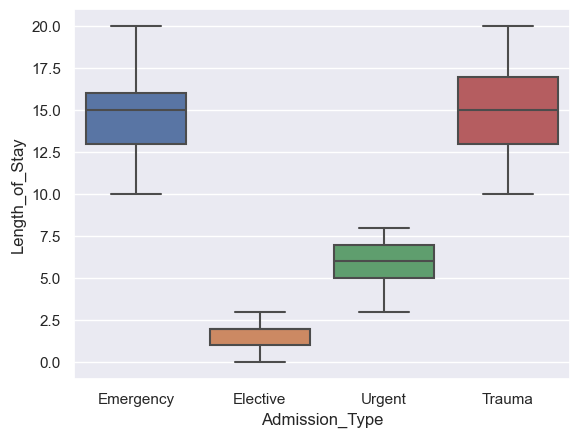

In [110]:
# Relationship between Admission_Type and Length_of_Stay

sns.boxplot(data=data,x="Admission_Type",y="Length_of_Stay")

> 1. Emergency and trauma have highest length of stay

<Axes: xlabel='Gender', ylabel='Length_of_Stay'>

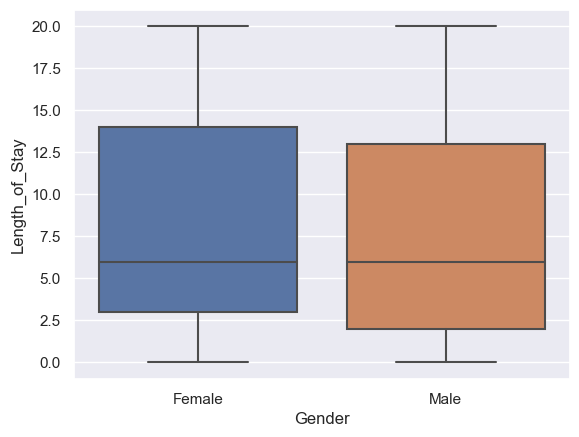

In [111]:
# Relationship between Gender and Length_of_Stay

sns.boxplot(data=data,x="Gender",y="Length_of_Stay")

>> 1. Gender does not have any impact on length of stay

<Axes: xlabel='Admission_Severity', ylabel='Length_of_Stay'>

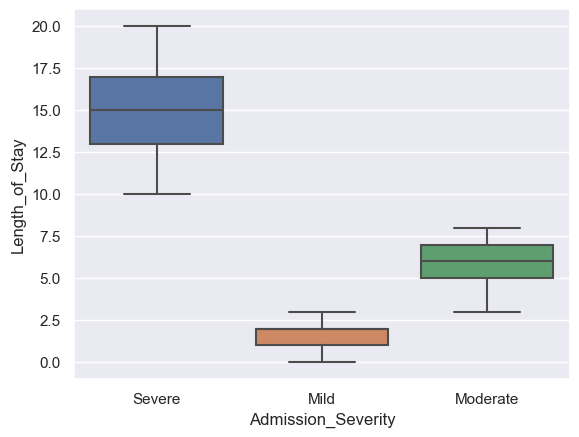

In [112]:
# Relationship between Admission_Severity and Length_of_Stay

sns.boxplot(data=data,x="Admission_Severity",y="Length_of_Stay")

>> 1. Admission severity gonna contribute a lot in predicting the LOS

<Axes: xlabel='Insurance_Type', ylabel='Length_of_Stay'>

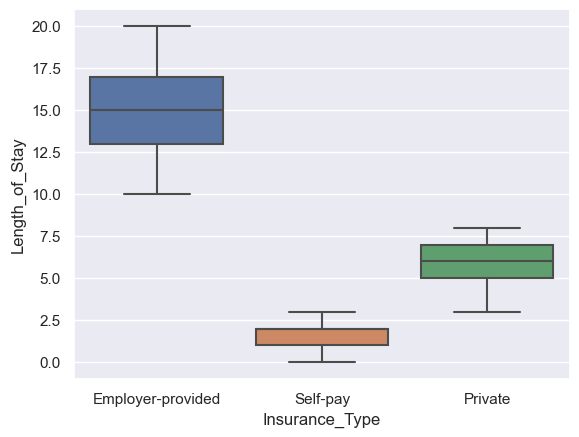

In [113]:
# Relationship between Insurance_Type and Length_of_Stay

sns.boxplot(data=data,x="Insurance_Type",y="Length_of_Stay")

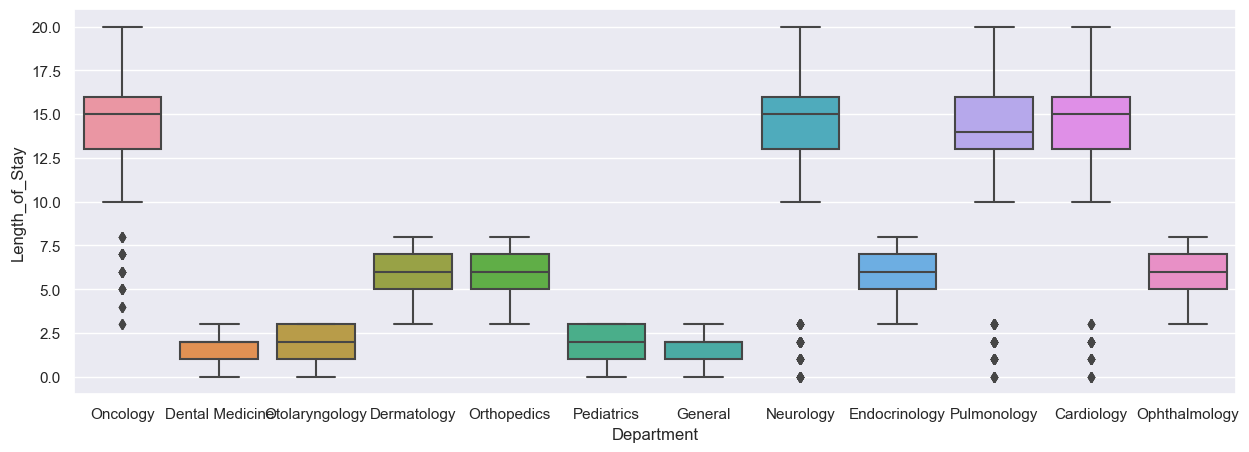

In [114]:
# Relationship between Department and Length_of_Stay
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
sns.boxplot(data=data,x="Department",y="Length_of_Stay")
sns.set_theme("notebook")

### Findings

>> 1. Oncology, Pulmonology, Cardiology, neurology departments have higher LOS
>> 2. Ophthalmology,  Orthopedics, Dermatology, Endocrinology departments have second higher LOS
>> 3. Other deportments have lesser LOS

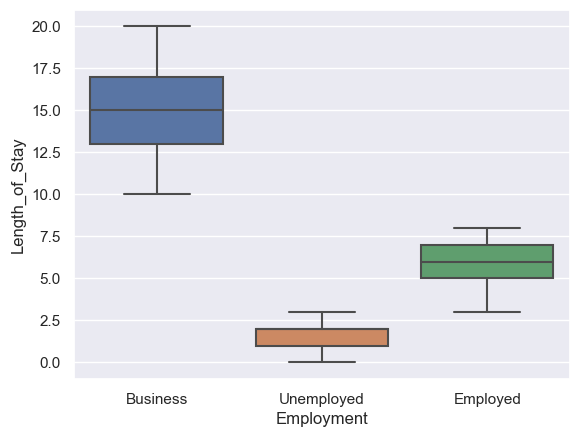

In [115]:
# Relationship between Employment and Length_of_Stay

sns.boxplot(data=data,x="Employment",y="Length_of_Stay")
sns.set_theme("notebook")

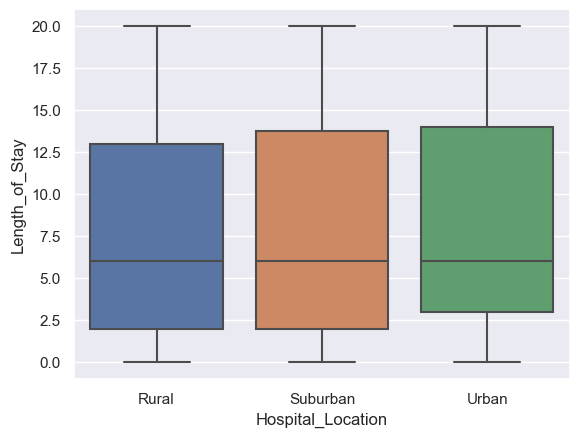

In [116]:
# Relationship between Employment and Length_of_Stay

sns.boxplot(data=data,x="Hospital_Location",y="Length_of_Stay")
sns.set_theme("notebook")

## Findings

>> 1. Hospital location does not make ny difference

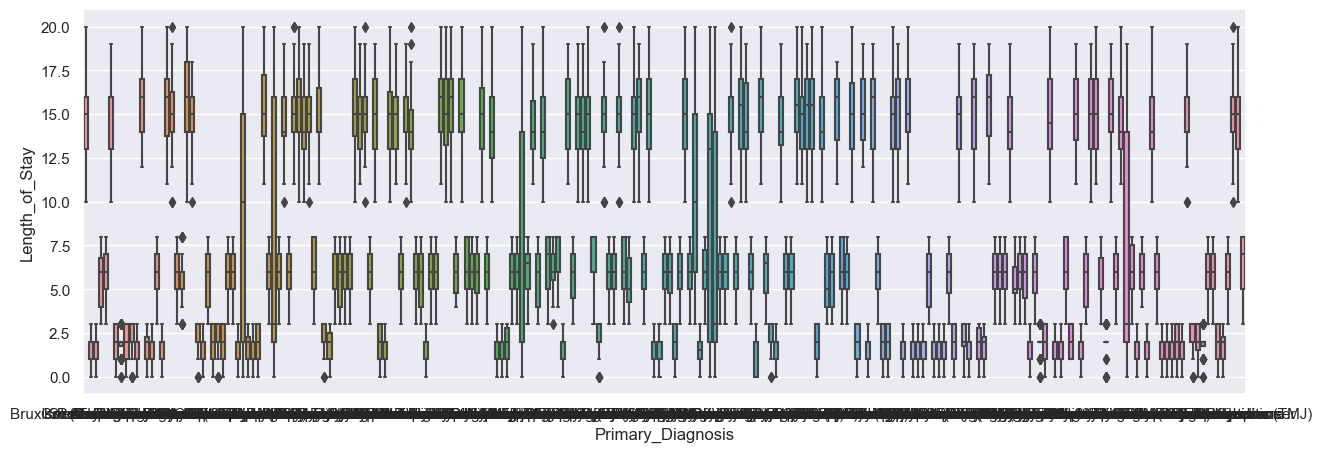

In [117]:
# Relationship between Employment and Length_of_Stay
plt.figure(figsize=(15,5))
sns.boxplot(data=data,x="Primary_Diagnosis",y="Length_of_Stay")
sns.set_theme("notebook")

In [118]:
# Creating new feature called no of Comorbidities

data["No_Comorbidities"]  = data["Comorbidities"].apply(lambda x: len(str(x).split(",")))

<Axes: xlabel='No_Comorbidities', ylabel='Length_of_Stay'>

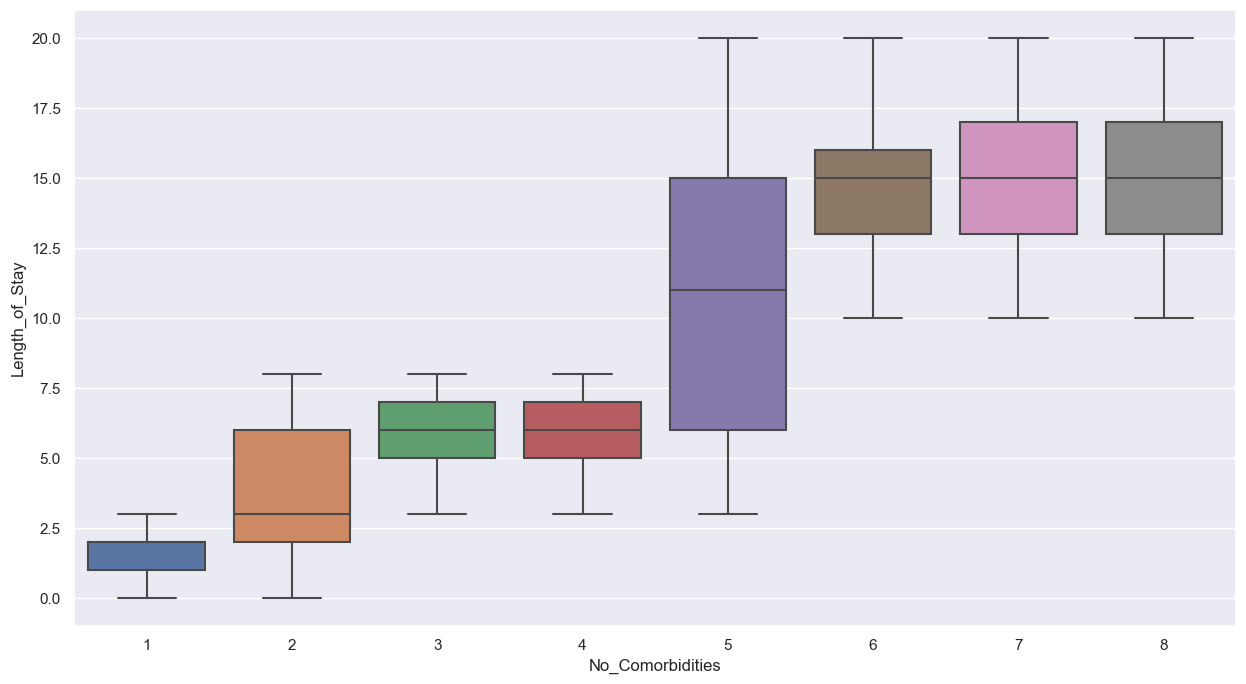

In [119]:
plt.figure(figsize=(15,8))

sns.boxplot(data=data,x="No_Comorbidities",y="Length_of_Stay")

### Findings

>> 1. It is clear that those who have many Comorbidities have higher LOS

<Axes: xlabel='Num_Imaging_Tests', ylabel='Length_of_Stay'>

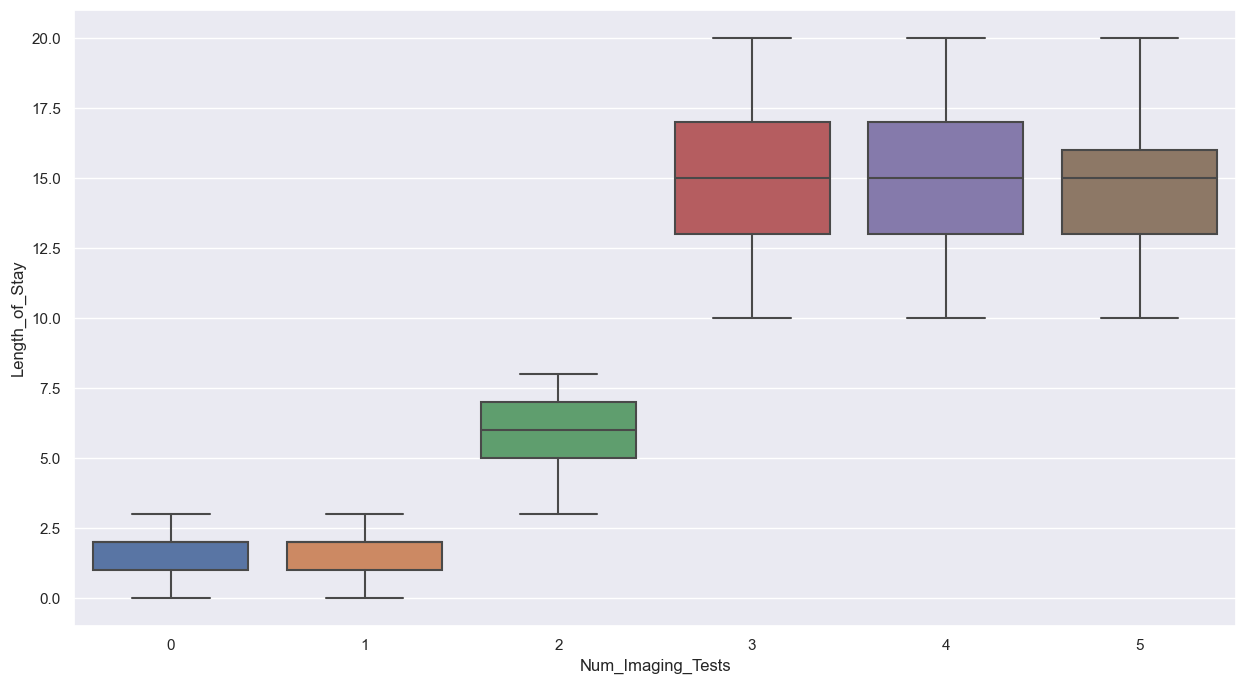

In [120]:
plt.figure(figsize=(15,8))

sns.boxplot(data=data,x="Num_Imaging_Tests",y="Length_of_Stay")

<Axes: xlabel='Num_Visits', ylabel='Length_of_Stay'>

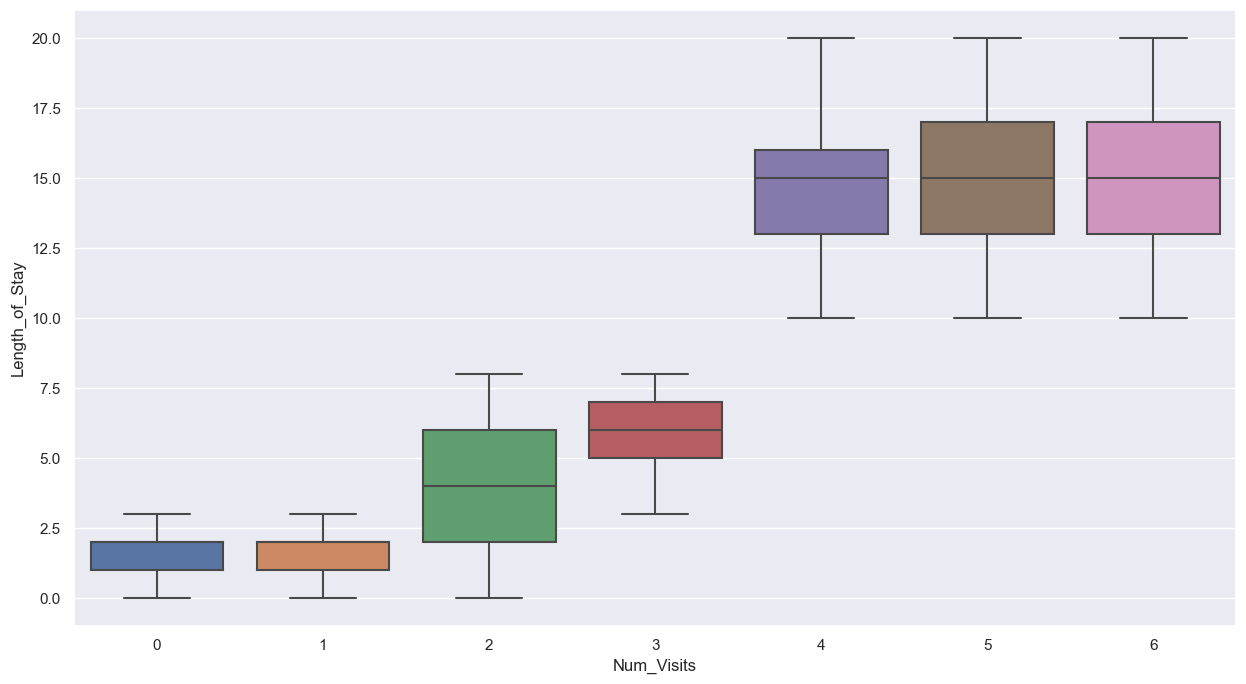

In [121]:
plt.figure(figsize=(15,8))

sns.boxplot(data=data,x="Num_Visits",y="Length_of_Stay")

<Axes: xlabel='Num_Lab_Tests', ylabel='Length_of_Stay'>

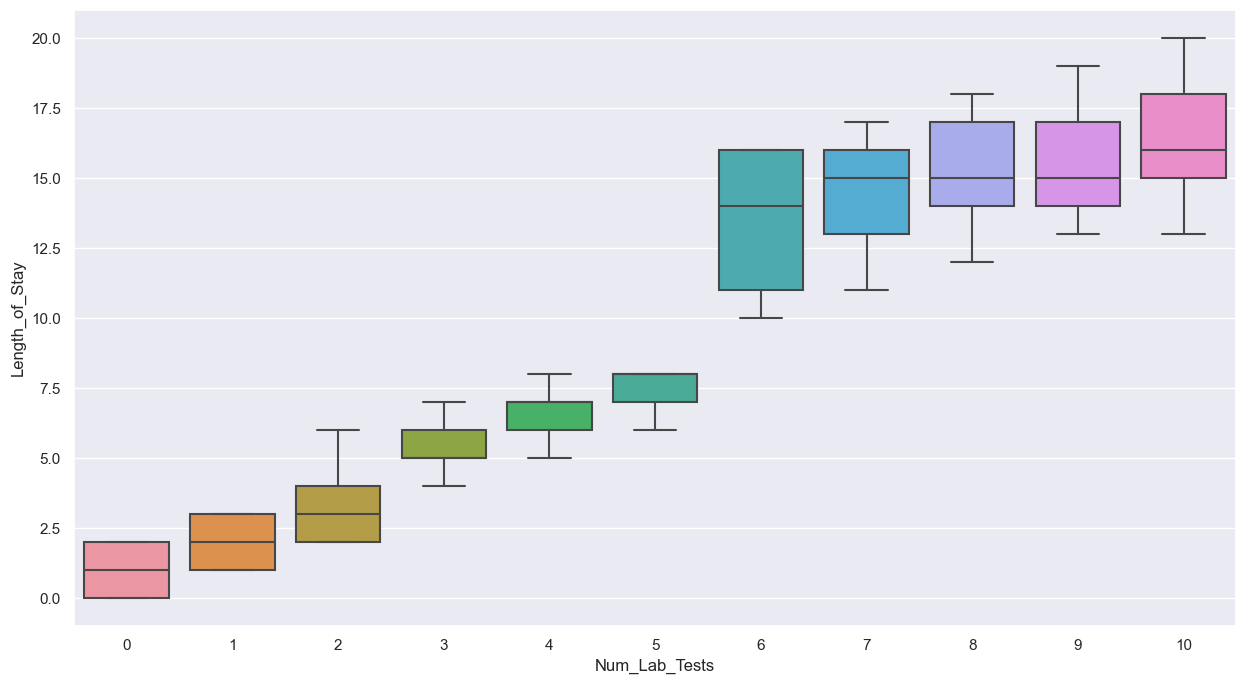

In [122]:
plt.figure(figsize=(15,8))

sns.boxplot(data=data,x="Num_Lab_Tests",y="Length_of_Stay")

<Axes: xlabel='Num_Medications', ylabel='Length_of_Stay'>

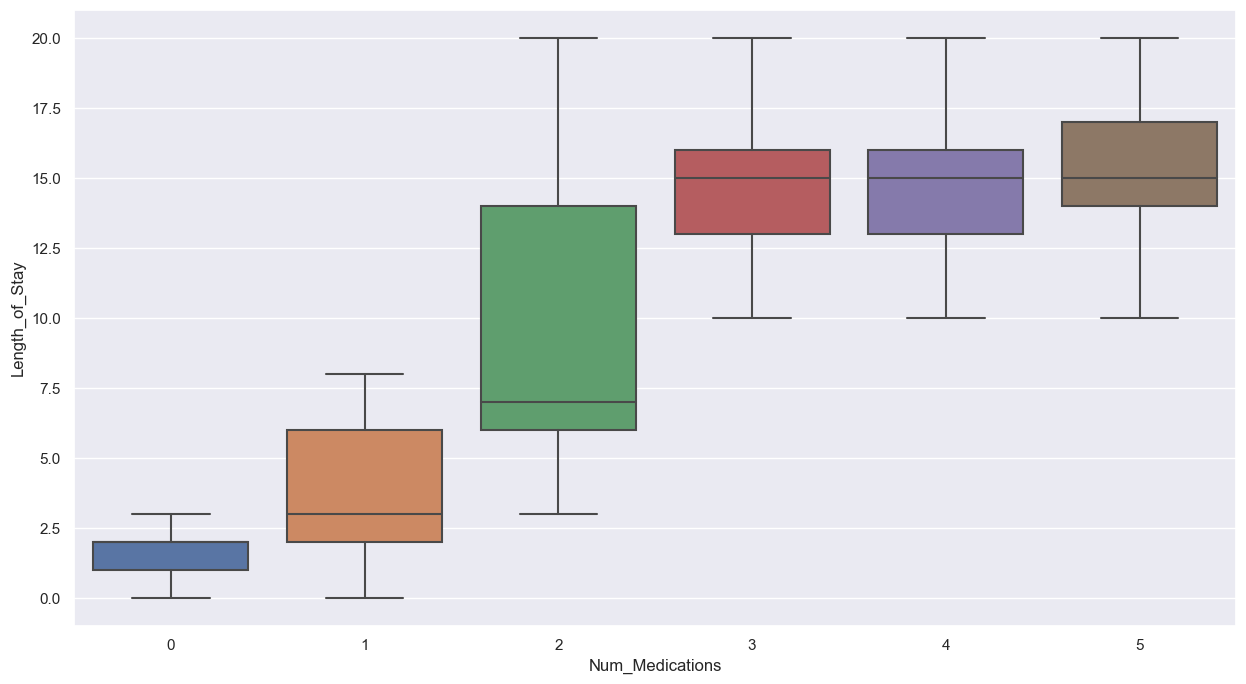

In [123]:
plt.figure(figsize=(15,8))

sns.boxplot(data=data,x="Num_Medications",y="Length_of_Stay")

# Model Building

In [136]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import pandas as pd

### 1. Data Pre-Processing

In [137]:
data = pd.read_csv("hospital_length_of_stay_dataset2.csv")

In [138]:
# Fill NaN values
data["Comorbidities"].fillna(0,inplace=True)

# Creating new feature called no of Comorbidities

data["No_Comorbidities"]  = data["Comorbidities"].apply(lambda x: len(str(x).split(",")))


# Drop Comorbidities
data.drop(["Comorbidities"],axis=1,inplace=True)


In [139]:
# Droping unwanted columns

data.drop(["Gender","Hospital","Hospital_Location"],axis=1,inplace=True)
data.drop(["Primary_Diagnosis"],axis=1,inplace=True)


### 2. Feature Engineering

In [140]:
# Splitting categorical and numerical features

cat_columns = ['Admission_Type', 'Admission_Severity','Insurance_Type', 'Employment', 'Department']

num_columns = [i for i in data.columns if i not in cat_columns+['Length_of_Stay']]

# data[cat_columns].head(2),data[num_columns].head(2)

In [141]:
# Getting OneHotEncoding for catgorical value

for col in cat_columns:

    data[col] = data[col].astype("category")

dummies = pd.get_dummies(data[cat_columns],drop_first=True)

data.drop(cat_columns,axis=1,inplace=True)


In [142]:
data_new = pd.concat([data,dummies],axis=1)

In [143]:
# Splitting data into train test split

target,features = data_new["Length_of_Stay"],data_new.drop(["Length_of_Stay"],axis=1)


x_train, x_test, y_train, y_test = train_test_split(features, target)

In [144]:
x_train.shape,y_train.shape

((7500, 27), (7500,))

In [145]:
model = XGBRegressor(n_estimators=100, max_depth=6,reg_lambda=50)

model.fit(x_train,y_train)

### Evaluating the model

from sklearn.metrics import mean_absolute_error, r2_score,mean_squared_error

predicted = model.predict(x_test)

print("R2 Score is : ",r2_score(predicted,y_test))

print("Mean Squared Error is : ",mean_squared_error(predicted,y_test))

print("Mean Absolute Error is : ",mean_absolute_error(predicted,y_test))

R2 Score is :  0.9999993174150442
Mean Squared Error is :  2.2139887779287136e-05
Mean Absolute Error is :  0.0023058773526223376


In [146]:
for i,j in zip(model.feature_names_in_[np.argsort(model.feature_importances_)[::-1]],model.feature_importances_[np.argsort(model.feature_importances_)[::-1]]):

    print(i,":",j)


Length_of_Stay_Previous : 0.49926567
Num_Imaging_Tests : 0.4872292
Num_Lab_Tests : 0.013477312
Num_Medications : 2.5707266e-05
Age : 6.554185e-07
Admission_Type_Trauma : 4.1786438e-07
No_Comorbidities : 3.464893e-07
Num_Visits : 1.9903484e-07
Department_Oncology : 1.7922537e-07
Department_Neurology : 1.5300206e-07
Department_Pulmonology : 1.0625248e-07
Admission_Type_Emergency : 6.6597394e-08
Department_Ophthalmology : 9.690765e-09
Department_Orthopedics : 6.4885826e-09
Department_Dermatology : 1.507658e-09
Employment_Unemployed : 0.0
Employment_Employed : 0.0
Department_Pediatrics : 0.0
Insurance_Type_Private : 0.0
Admission_Severity_Severe : 0.0
Admission_Severity_Moderate : 0.0
Admission_Type_Urgent : 0.0
Department_Dental Medicine : 0.0
Department_Endocrinology : 0.0
Department_General : 0.0
Department_Otolaryngology : 0.0
Insurance_Type_Self-pay : 0.0


In [268]:
# FIne tuning

from sklearn.model_selection import GridSearchCV, train_test_split

In [411]:
# Define the parameter grid for grid search
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [1,2,3, 4,5, 6,7,8],
    'n_estimators': [40,60,80,100, 200, 300,400],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=3, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
                         'n_estimators': [40, 60, 80, 100, 200, 300, 400]},
             scoring='neg_mean_squared_error')

In [413]:
print("Best Score: ", grid_search.best_score_)

Best Score:  -1.389550853942812e-08
